In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import matplotlib.pyplot as plt


PREPARING DATA FOR TRAINING MODEL


In [9]:
import os

# Укажите путь к папке с данными
dataset_path = r'C:\Users\77053\.cache\kagglehub\datasets\itamargr\dfdc-faces-of-the-train-sample\versions\2'

# Папки с данными для классов fake и real
train_fake_dir = os.path.join(dataset_path, 'train', 'fake_balanced1')
train_real_dir = os.path.join(dataset_path, 'train', 'real')

val_fake_dir = os.path.join(dataset_path, 'Validation', 'Fake')
val_real_dir = os.path.join(dataset_path, 'Validation', 'Real')

# Подсчёт изображений в каждой из папок
train_fake_count = len([f for f in os.listdir(train_fake_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
train_real_count = len([f for f in os.listdir(train_real_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

val_fake_count = len([f for f in os.listdir(val_fake_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
val_real_count = len([f for f in os.listdir(val_real_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

# Вывод информации для train
print(f"Количество изображений в классе 'Fake' (train): {train_fake_count}")
print(f"Количество изображений в классе 'Real' (train): {train_real_count}")

# Вывод информации для validation
print(f"Количество изображений в классе 'Fake' (validation): {val_fake_count}")
print(f"Количество изображений в классе 'Real' (validation): {val_real_count}")

# Общий подсчёт изображений для train и validation
total_train_count = train_fake_count + train_real_count
total_val_count = val_fake_count + val_real_count
total_count = total_train_count + total_val_count

print(f"\nОбщее количество изображений (train): {total_train_count}")
print(f"Общее количество изображений (validation): {total_val_count}")
print(f"Общее количество изображений (train + validation): {total_count}")


Количество изображений в классе 'Fake' (train): 54039
Количество изображений в классе 'Real' (train): 20699
Количество изображений в классе 'Fake' (validation): 24765
Количество изображений в классе 'Real' (validation): 6029

Общее количество изображений (train): 74738
Общее количество изображений (validation): 30794
Общее количество изображений (train + validation): 105532


BALANCING DATA BY REDUCING DATA FROM FAKE CLASS

In [ ]:
import os
import shutil
import random


train_dir = r'C:\Users\77053\.cache\kagglehub\datasets\itamargr\dfdc-faces-of-the-train-sample\versions\2\train'
real_dir = os.path.join(train_dir, 'real')
fake_dir = os.path.join(train_dir, 'fake')

# Папки для сбалансированных данных
balanced_fake_dir = os.path.join(train_dir, 'fake_balanced')


if not os.path.exists(balanced_fake_dir):
    os.makedirs(balanced_fake_dir)


real_count = len(os.listdir(real_dir))


fake_images = os.listdir(fake_dir)


if len(fake_images) > real_count:
    
    undersampled_fake_images = random.sample(fake_images, real_count)
    
  
    for image in undersampled_fake_images:
        src_path = os.path.join(fake_dir, image)
        dst_path = os.path.join(balanced_fake_dir, image)
        shutil.copy(src_path, dst_path)

    print(f"Количество изображений в 'fake_balanced1' после undersampling: {len(undersampled_fake_images)}")
else:
    print(f"Количество изображений в 'fake' уже равно или меньше, чем в 'real' ({len(fake_images)} vs {real_count})")

print(f"Количество изображений в 'real': {real_count}")


In [ ]:

dataset_path = r'C:\Users\77053\.cache\kagglehub\datasets\itamargr\dfdc-faces-of-the-train-sample\versions\2'


train_dir = os.path.join(dataset_path, 'train')  # Папка с обучающими данными
val_dir = os.path.join(dataset_path, 'validation')  # Папка с валидационными данными


train_data = image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=16  
)

val_data = image_dataset_from_directory(
    val_dir,
    image_size=(256, 256),
    batch_size=16
)

# Нормализация данных (перевод пикселей в диапазон [0, 1])
train_data = train_data.map(lambda x, y: (x / 255.0, y))
val_data = val_data.map(lambda x, y: (x / 255.0, y))

train_data = train_data.take(500)


val_data = val_data.take(200)



train_data = train_data.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Found 147418 files belonging to 3 classes.
Found 30794 files belonging to 2 classes.


EXPLORING DATASET

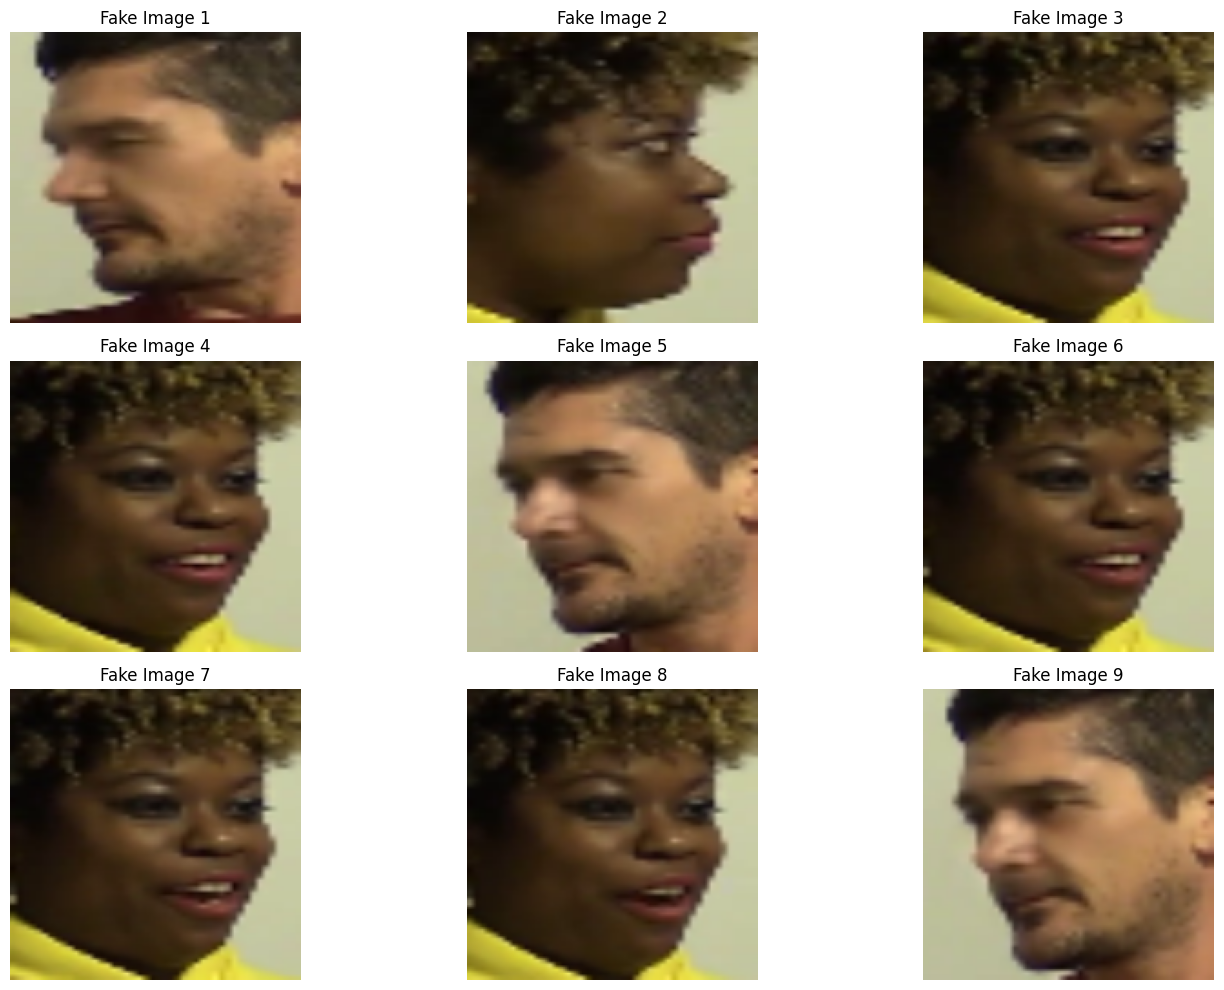

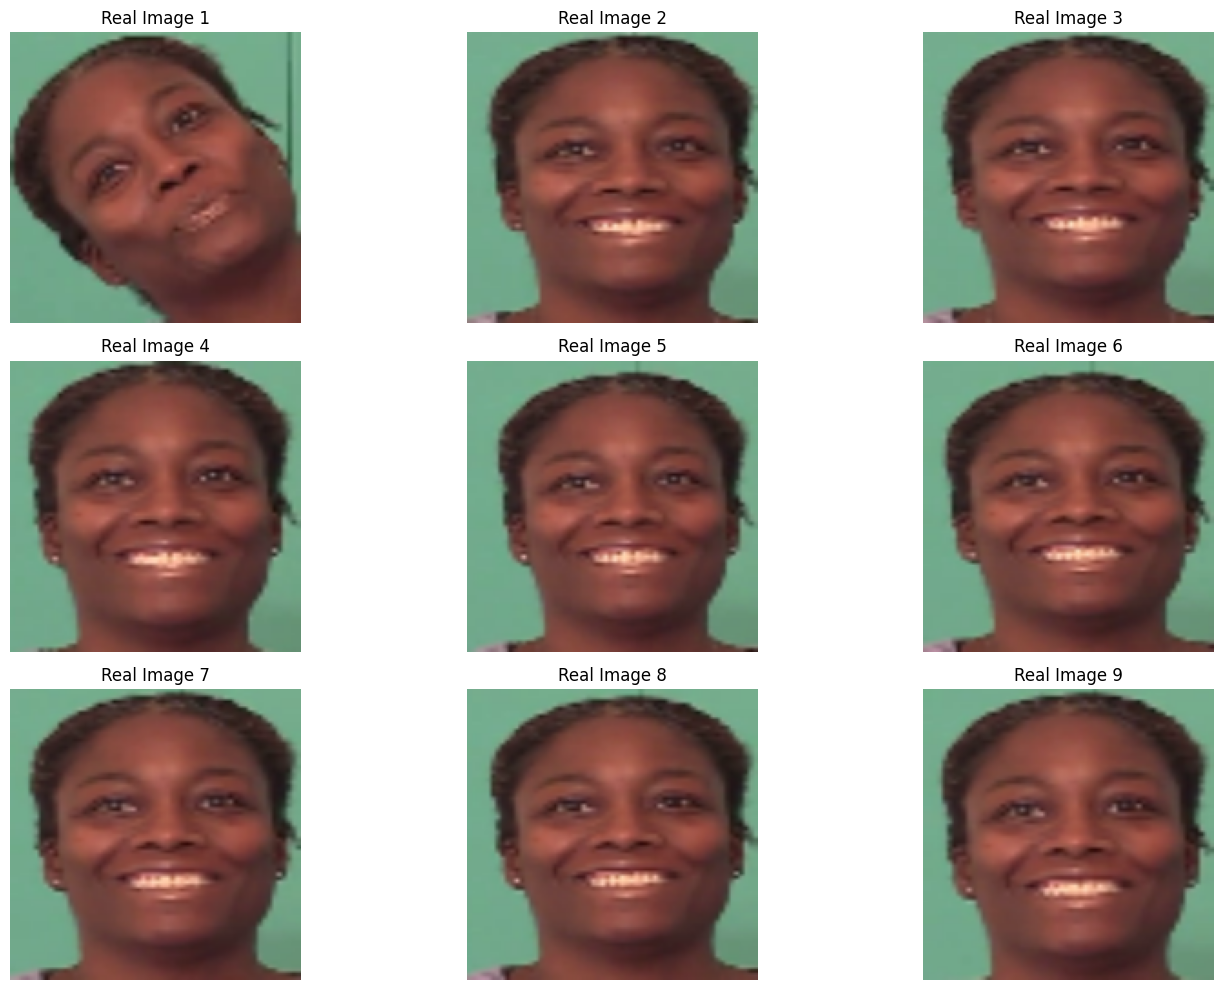

In [ ]:

from PIL import Image


train_dir = os.path.join(dataset_path, 'train')


fake_dir = os.path.join(train_dir, 'fake_balanced1')
real_dir = os.path.join(train_dir, 'real')


fake_images = [f for f in os.listdir(fake_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]


plt.figure(figsize=(15, 10))
for i, image_file in enumerate(fake_images[:9]):  
    image_path = os.path.join(fake_dir, image_file)
    img = Image.open(image_path)
    
    plt.subplot(3, 3, i+1)  
    plt.imshow(img)
    plt.axis('off')  
    plt.title(f"Fake Image {i+1}")

plt.tight_layout()
plt.show()


if os.path.exists(real_dir):
    real_images = [f for f in os.listdir(real_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]


    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(real_images[:9]):  
        image_path = os.path.join(real_dir, image_file)
        img = Image.open(image_path)

        plt.subplot(3, 3, i+1)  
        plt.imshow(img)
        plt.axis('off')  
        plt.title(f"Real Image {i+1}")

    plt.tight_layout()
    plt.show()

ADDING DATA AUGMENTATION

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),  # Горизонтальное отражение
    layers.RandomRotation(0.2),  # Случайная вращение на 20%
    layers.RandomZoom(0.2),  # Случайное увеличение или уменьшение на 20%
    layers.RandomContrast(0.2),  # Случайное изменение контраста
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2)  # Случайное смещение
])

COMPILE A NEURAL NETWORK BASED ON THE PRE-TRAINED MobileNETV2 MODEL

In [ ]:
base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


base_model.trainable = False


baseline_model = models.Sequential([
    data_augmentation,  
    base_model,  
    layers.GlobalAveragePooling2D(),  
    layers.Dense(256, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid')  
])


baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  
    metrics=['accuracy']
)


baseline_model.summary()

C:\Users\77053\AppData\Local\Temp\ipykernel_19644\1252546945.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

TRAINING BASELINE MODEL 

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('baseline_deepfake_model.keras', save_best_only=True)


history_baseline = baseline_model.fit(
    train_data,
    epochs=2,  
    validation_data=val_data,
    callbacks=[early_stopping, checkpoint]
)


val_loss, val_accuracy = baseline_model.evaluate(val_data)


print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 210s 409ms/step - accuracy: 0.7611 - loss: 0.5370 - val_accuracy: 0.7956 - val_loss: 0.5169
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 189s 378ms/step - accuracy: 0.7973 - loss: 0.4624 - val_accuracy: 0.8000 - val_loss: 0.5103
200/200 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - accuracy: 0.7974 - loss: 0.5039
Validation Loss: 0.5103452205657959
Validation Accuracy: 0.800000011920929


EXTENDING THE PREVIOUS MODEL MAKING IT MORE POWERFUL AND FLEXIBLE

In [ ]:

base_model.trainable = True


enhanced_model = models.Sequential([
    base_model,  # Pre-trained MobileNetV2 model
    layers.GlobalAveragePooling2D(),  # Global Average Pooling to reduce dimensionality
    layers.BatchNormalization(),  # Batch Normalization for better convergence
    layers.Dense(512, activation='relu'),  # Dense layer for more representation power
    layers.Dropout(0.5),  # Dropout for regularization to avoid overfitting
    layers.Dense(1, activation='sigmoid')  # Final dense layer for binary classification
])


enhanced_model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']  
)

enhanced_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,919,489 (11.14 MB)

 Trainable params: 2,882,817 (11.00 MB)

 Non-trainable params: 36,672 (143.25 KB)

TRAINING MODEL

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('enhanced_deepfake_model.keras', save_best_only=True)
enhanced_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC'] 
)

history_enhanced = enhanced_model.fit(
    train_data,
    epochs=2,
    validation_data=val_data,
    callbacks=[early_stopping, checkpoint]
)


val_loss, val_accuracy, val_precision, val_recall, val_auc = enhanced_model.evaluate(val_data)


print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation AUC: {val_auc}")


Epoch 1/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - AUC: 0.6949 - Precision: 0.4764 - Recall: 0.3633 - accuracy: 0.7663 - loss: 0.7595 - val_AUC: 0.5000 - val_Precision: 0.1897 - val_Recall: 1.0000 - val_accuracy: 0.1897 - val_loss: 21.3139
Epoch 2/2
500/500 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - AUC: 0.8936 - Precision: 0.7136 - Recall: 0.6844 - accuracy: 0.8658 - loss: 0.3501 - val_AUC: 0.6215 - val_Precision: 0.2026 - val_Recall: 0.9671 - val_accuracy: 0.2719 - val_loss: 6.0025
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - AUC: 0.6204 - Precision: 0.2054 - Recall: 0.9727 - accuracy: 0.2840 - loss: 5.9820
Validation Loss: 6.002499580383301
Validation Accuracy: 0.2718749940395355
Validation Precision: 0.2026233971118927
Validation Recall: 0.967051088809967
Validation AUC: 0.6215053796768188


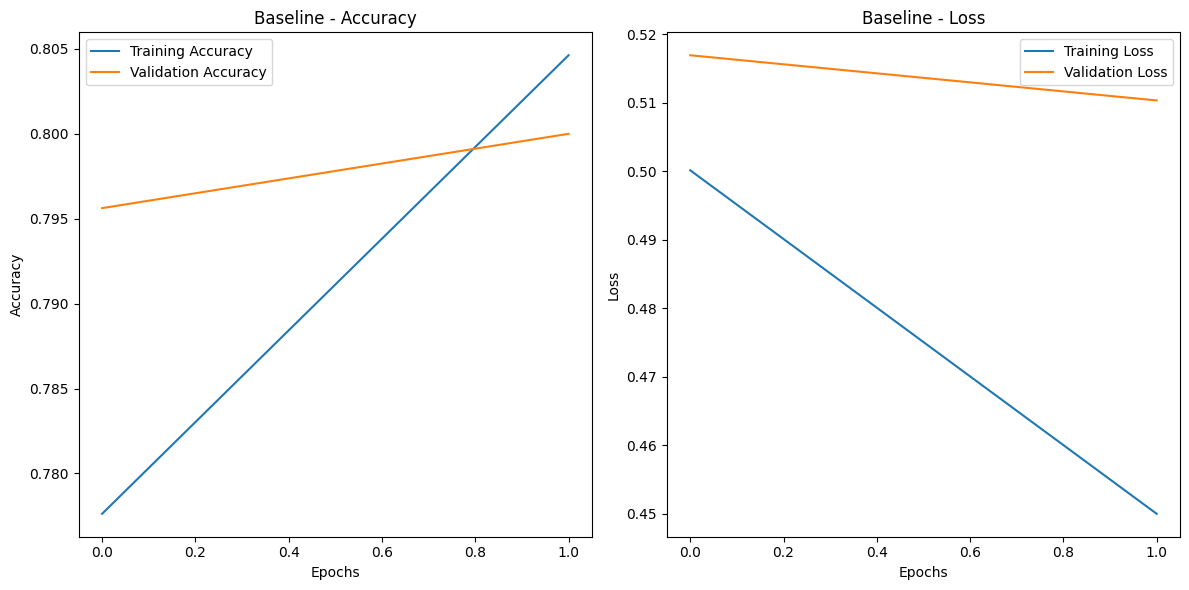

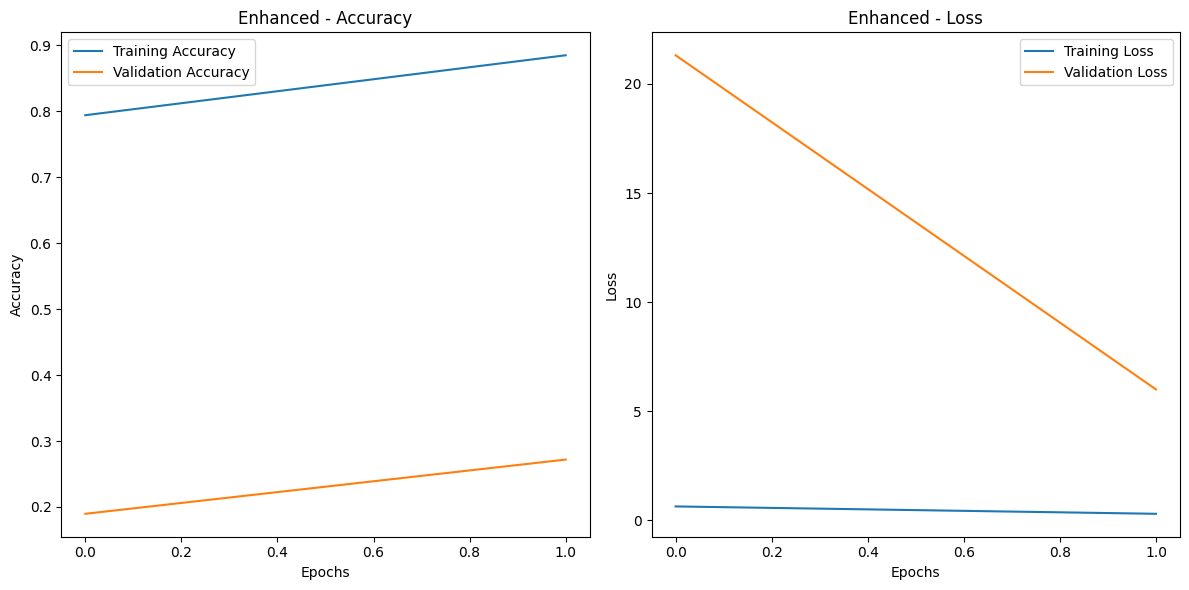

In [ ]:

def plot_training_history(history, model_type='Baseline'):
    plt.figure(figsize=(12, 6))

  
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history_baseline, model_type='Baseline')


plot_training_history(history_enhanced, model_type='Enhanced')


In [ ]:
import cv2

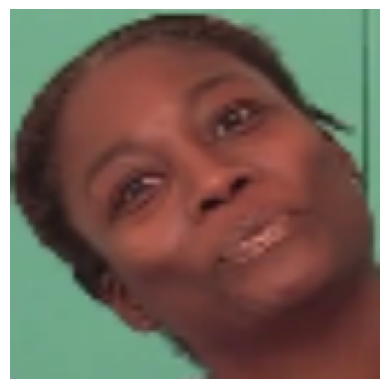

In [ ]:
img = cv2.imread('real.jpg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.axis('off')  
plt.show()


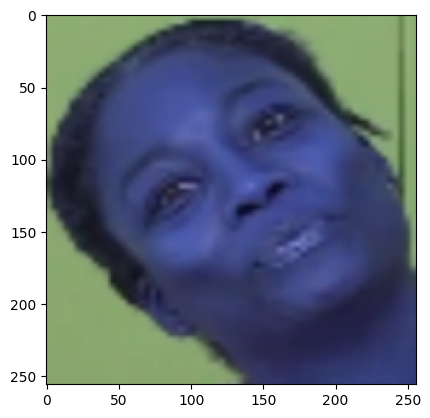

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image
import os


baseline_model = load_model('baseline_deepfake_model.keras')  
enhanced_model = load_model('enhanced_deepfake_model.keras')  

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_image(image_path, target_size=(256, 256)):
    try:

        img = Image.open(image_path).convert('RGB')  
        img = img.resize(target_size)  
        
      
        img_array = np.array(img)  
        img_array = np.expand_dims(img_array, axis=0)  
        
        # Используем MobileNetV2 предобработку
        img_array = preprocess_input(img_array)
        
        return img_array
    except Exception as e:
        print(f"Ошибка при обработке изображения: {e}")
        return None



def predict_image(model, image_path):
    
    img_array = preprocess_image(image_path)
    if img_array is not None:
        
        prediction = model.predict(img_array)
        
       
        print(f"Предсказание: {prediction[0][0]}")  # Вероятность того, что это "FAKE"
        
       
        confidence = prediction[0][0]
        result = "FAKE" if confidence > 0.5 else "REAL"
        
     
        print(f"Результат: {result}")
        print(f"Уверенность: {confidence * 100:.2f}%")
        return result, confidence
    else:
        print("Ошибка при обработке изображения.")
        return None, None



test_image_paths = [
    r'C:\Users\77053\Documents\vs code\deepfake1\fake_76.jpg',  # Замените на правильный путь к изображению
    r'C:\Users\77053\Documents\vs code\deepfake\fake.jpg'   # Замените на правильный путь к изображению
]


for image_path in test_image_paths:
    print(f"\nТестирование изображения: {image_path}")
    result, confidence = predict_image(baseline_model, image_path)  # Можете использовать enhanced_model для тестирования улучшенной модели

    if result is not None:
        print(f"Предсказание: {result} с уверенностью {confidence * 100:.2f}%")
